# A Casual Analysis of Public Transportation in New York City

### Author: Nathaniel del Rosario A17562063, Nathaniel Brodie A15874575
[Rubric](file:///Users/nathaniel.delrosario/Downloads/Project_final_template.pdf)

### Introduction, Question(s), & Hypothesis

The New York City public transportation is arguably one of the best in North America, providing many different methods such as metro, ride share, and bike as the most common. However, it is not a perfect system, possessing its own set of shortcomings. For example, compared to Tokyo's public transportation infrastructure, NYC's system is not as expansive and under serves more areas compared to Tokyo. Considering such context, the question arises, "just how under served are parts of New York City in the scope of public transportation?" and furthermore, are there any effects in other domains due to these under served areas?

I hypothesize that there are in fact different factors whose effects that are correlated with some areas being under served specifically by the NYC metro such as these areas being more likely to experience more ride share and bike usage. Upon witnessing any correlation, the next question becomes “is there causation as well?” Answering such uncertainty is the goal of this project.

This question is important because it involves using population, ridership, geo-spatial, and tract data to help people not only understand their commute as well as identify potential causality between different events and transportation accessibility. On average people will spend at least an hour commuting to and from work and school, and this is a huge chunk of our day (1/16 if you get a full 8 hours of sleep!) Additionally, public transportation companies can benefit greatly from this analysis as they can modify their strategy to appeal more to commuters and plan where to expand service to those who are under served. Lastly, the average citizen would benefit from this information because it could convince them to take public transportation instead of contributing to the increasing problem of traffic congestion in major metropolitan areas.

### Related Work

Scarlett T. Jin, Hui Kong & Daniel Z. Sui (2019) Uber, Public Transit, and Urban Transportation Equity: A Case Study in New York City, The Professional Geographer, 71:2, 315-330, DOI: 10.1080/00330124.2018.1531038

- Takeaway: distribution of Uber services is highly unequal, Correlation analysis shows that there tend to be fewer Uber pickups in low-income areas. For this project, we want to see if Uber pickups also correlate with low income areas.

Tang, J.; Gao, F.; Liu, F.; Zhang, W.; Qi, Y. Understanding Spatio-Temporal Characteristics of Urban Travel Demand Based on the Combination of GWR and GLM. Sustainability 2019, 11, 5525. https://doi.org/10.3390/su11195525

- Takeaway: Results suggest that most taxi trips are concentrated in a fraction of the geographical area. Variables including road density, subway accessibility, Uber vehicle, point of interests (POIs), commercial area, taxi-related accident and commuting time have significant effects on travel demand,

Hess, D. B., & Almeida, T. M. (2007). Impact of Proximity to Light Rail Rapid Transit on Station-area Property Values in Buffalo, New York. Urban Studies, 44(5-6), 1041-1068. https://doi.org/10.1080/00420980701256005

- Takeaway: this study assesses the impact of proximity to light rail transit stations on residential property values in Buffalo, New York, where light rail has been in service for 20 years, but population is declining and ridership is decreasing. Though not directly related to what our analysis is, it looks at the contrary (how income / property values are affected by rail access)

Freeman, L., Neckerman, K., Schwartz-Soicher, O. et al. Neighborhood Walkability and Active Travel (Walking and Cycling) in New York City. J Urban Health 90, 575–585 (2013). https://doi.org/10.1007/s11524-012-9758-7

- Neighborhood proximity / walkability is associated w/ higher engagement in active travel, which is defined as walking and cycling.

### Packages & Libraries

The packages and libraries used for our analysis are ArcGIS Online (including all ArcGIS features and analysis functions, Python, GeoPandas, shapely Point geometry), numpy / math for calculations and manipulation.

We use ArcGIS for the feature layer loading and data sourcing, Python for all of the code, GeoPandas for manipulating the data through aggregations, spatial joins, and plotting. These packages are the same as in the project proposal so we stayed on track in that respect. Additionally, we used numpy and math for some calculations regarding unit conversion for buffer distances. This was something that I did not include on the proposal specifically, though it was a needed addition.

In [1]:
import pandas as pd
import numpy as np
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor, FeatureLayerCollection, FeatureSet, FeatureCollection, FeatureLayer
from arcgis.features.use_proximity import create_buffers
from IPython.display import display
import os

import getpass
username = input('Enter username: ')
password = getpass.getpass("Enter password: ")
gis = GIS(username=username, password=password)

Enter username: dsc170wi24_8
Enter password: ········


In [2]:
m = gis.map('New York, NY')

### Data Sources

1. [Metro Stations](https://ucsdonline.maps.arcgis.com/home/item.html?id=d52e004c3bda4397ae2145257ede1200) 
- The feature service includes multiple features layers of metro stops throughout New York. We used layer 3 since it has the stops for Manhattan, Queens, and Brooklyn. The dataset includes relevant fields such as tracts / boundaries and the point geometry for each station. 

2. [Bike Stations](https://ucsdonline.maps.arcgis.com/home/item.html?id=f0679d1e4ca44350abed2a48eecb7eb9) 
- The feature layer includes points of Citi Bike stations throughout New York. It also has stations for Manhattan, Queens, and Brooklyn. The dataset includes relevant fields such as tracts / boundaries and the point geometry for each station just like the metro stations.

3. [Bike Stations Intersect w/ Low Income](https://ucsdonline.maps.arcgis.com/home/item.html?id=dc2e07a9af82464e94318c7dc71fc084) 
- The feature layer includes points of Citi bike stations throughout New York as they interesect with Low income tracts. It also has stations for Manhattan, Queens, and Brooklyn. The dataset includes relevant fields such as tracts / boundaries and the point geometry for each station just like the metro station and the income field

4. [Uber and Lyft Dropoffs](https://ucsdonline.maps.arcgis.com/home/item.html?id=072e86100593482887a99aaaac8b2ada)
- The feature layer includes points of Uber and Lyft pickups and dropoffs throughout New York (Manhattan, Queens, and Brooklyn). The dataset includes relevant fields such as tracts / boundaries and the point geometry for each dropoff and pickup just like the metro station. Additionally it includes times for each as well incase any time series analysis is needed.

5. [Income Distribution](https://ucsdonline.maps.arcgis.com/home/item.html?id=00847778292e466082388a18230f41ba) 
- The feature layer includes the income distribution by tract for New York (Manhattan, Queens, and Brooklyn). Like the others, dataset includes relevant fields such as tracts / boundaries and the median income as well.

6. [Census Tracts](https://ucsdonline.maps.arcgis.com/home/item.html?id=9bb695ac4b874286ab6645e4196f19bb) 
- This is the census tract layer that will be useful for just isolating the boundaries. It includes polygons for the boundaries.

7. [Gentrification](https://ucsdonline.maps.arcgis.com/home/item.html?id=f8f47e4166d34862a6d340d8e2dcb55f) 
- This is a choropleth layer that will be useful for looking at gentrifictation in addition to low income areas and how they relate to public transportation accessability.

8. [Low Income Census](https://ucsdonline.maps.arcgis.com/home/item.html?id=9bb695ac4b874286ab6645e4196f19bb) 
- Like the census tracts, this is the census tract layer by low income. It includes polygons for the boundaries.

Notes: 
- The datasets come from different years, but this was the closest grouping of years I could find on AGOL open source datasets. 
- Other useful data I could not find would have been average number of people who walk for each tract; however most datasets were only geared towards the 3 public transportation methods that this project ended up focusing on.

In [3]:
# get transport feature layers
metro_stops_fl = gis.content.get('d52e004c3bda4397ae2145257ede1200')
rideshare_fl = gis.content.get('072e86100593482887a99aaaac8b2ada')
bike_lanes_fl = gis.content.get('8aff6fb97ef546679e97b1696bfbf052')
bike_lane_low_income_intersect_fl = gis.content.get('dc2e07a9af82464e94318c7dc71fc084')
bike_station_low_income_intersect_fl = gis.content.get('f0679d1e4ca44350abed2a48eecb7eb9')

# get income layers
low_income_binary_fl = gis.content.get('9bb695ac4b874286ab6645e4196f19bb')
income_dist_fl = gis.content.get('00847778292e466082388a18230f41ba')
gentrification_fl = gis.content.get('f8f47e4166d34862a6d340d8e2dcb55f')

m.add_layer(metro_stops_fl)
m.add_layer(rideshare_fl)
m.add_layer(bike_lanes_fl)
m

MapView(layout=Layout(height='400px', width='100%'))

In [4]:
# append to each feature service: /0/query?where=1%3D1&outFields=*&f=geojson
# Income: https://services1.arcgis.com/HmwnYiJTBZ4UkySc/arcgis/rest/services/NYCMedianIncomeDistributions_WFL1/FeatureServer/0/query?where=1%3D1&outFields=*&f=geojson
# The rest are uploaded to https://github.com/natdosan/causal-analysis-nyc-transit

In [5]:
# Load Data into GeoDataFames (downloaded Feature Layers into json)
bike_stations = gpd.read_file('data/bike_stations.json')
bike_lane_low_income_intersections = gpd.read_file('data/bike_lane_low_income_intersections.json')
low_income_bike_station_intersections = gpd.read_file('data/low_income_bike_station_intersections.json')
uber_lyft_dropoffs = gpd.read_file('data/uber_lyft_dropoffs.json')
nyc_subway_stops = gpd.read_file('data/nyc_stations.json')
low_income_census = gpd.read_file('data/low_income_census.json')
nyc_gentrification = gpd.read_file('data/nyc_gentrification.json')
nyc_median_income = gpd.read_file('data/nyc_median_income.json')
nyc_boundaries = gpd.read_file('data/nyc_boundaries.json')

In [6]:
uber_lyft_dropoffs.head(1)

,OBJECTID_1,OBJECTID,Shape_Leng,zone,LocationID,borough,count_,DOLocationID,time_day,PULocationID,Shape__Area,Shape__Length,geometry
0,1,1,0.116357,Newark Airport,1,EWR,257837.0,1.0,Morning,NaN,7.903953e+07,37646.072282,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."


### Data Cleaning

Most of the datasets were very cleaned in the fields we needed. Counts did not need to be normalized before doing EDA, so we normalized any needed fields after, when we designed our regression model. Additionally, all GeoDataframes were in 4326 CRS, so there did not need to be any conversions. Overall, there was no strenuous cleaning needed with the data we found.

### Descriptive Statistics and Analysis

I combined these two parts of the rubric because my work for both kind of blended together; I continued to discover new things about the data as I did more plotting and joining

In [7]:
nyc_subway_stops.columns

Index(['FID', 'stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'trains',
       'structure', 'stop_id2', 'GEOID', 'NAMELSAD', 'geometry'],
      dtype='object')

In [8]:
bike_stations.columns

Index(['OBJECTID', 'tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender', 'geometry'],
      dtype='object')

In [9]:
uber_lyft_dropoffs.columns

Index(['OBJECTID_1', 'OBJECTID', 'Shape_Leng', 'zone', 'LocationID', 'borough',
       'count_', 'DOLocationID', 'time_day', 'PULocationID', 'Shape__Area',
       'Shape__Length', 'geometry'],
      dtype='object')

In [10]:
# spatial join for subway stations, bike stations, and rideshare dropoffs with census tracts
subway_stations_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry=nyc_subway_stops['geometry']), nyc_boundaries, how='inner', op='intersects')
bike_stations_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry=bike_stations['geometry']), nyc_boundaries, how='inner', op='intersects')
rideshare_dropoffs_with_tracts = gpd.sjoin(uber_lyft_dropoffs, nyc_boundaries, how='inner', op='intersects')

# Aggregate counts by census tract for subway stations, bike stations, and rideshare dropoffs
subway_station_counts = subway_stations_with_tracts.groupby('NTA2020').size()
bike_station_counts = bike_stations_with_tracts.groupby('NTA2020').size()
rideshare_dropoff_counts = rideshare_dropoffs_with_tracts.groupby('NTA2020').size()

subway_station_counts

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


NTA2020
BK0101    2
BK0102    3
BK0103    3
BK0104    6
BK0201    3
         ..
SI0202    3
SI0301    2
SI0302    2
SI0304    4
SI0305    3
Length: 141, dtype: int64

In [11]:
bike_station_counts

NTA2020
BK0101    15
BK0102    26
BK0103     5
BK0104    27
BK0201    11
BK0202    21
BK0203    19
BK0204     9
BK0261     5
BK0301    23
BK0302    12
BK0401    13
BK0601    48
BK0602    23
BK0702     2
BK0801    10
BK0802     9
BK0901     5
BK0902     4
BK5591     4
MN0101    24
MN0102    16
MN0191     3
MN0201    12
MN0202    14
MN0203    12
MN0301    12
MN0302    18
MN0303    23
MN0401    26
MN0402    14
MN0501    14
MN0502    20
MN0601     5
MN0602     6
MN0603    18
MN0604    15
MN0701    12
MN0702    19
MN0703    10
MN0801    13
MN0802    16
MN0803    14
MN0901    11
MN0902     1
MN1001    12
MN1002     3
MN1101    17
MN1102    21
MN6491    14
QN0101    10
QN0102     7
QN0103    15
QN0104     6
QN0105    22
QN0191     2
QN0201    17
QN0202     3
dtype: int64

In [12]:
rideshare_dropoff_counts

NTA2020
BK0101    173
BK0102    203
BK0103    195
BK0104    328
BK0201    112
         ... 
SI0305     71
SI0391     31
SI9561     15
SI9592     14
SI9593     23
Length: 261, dtype: int64

In [13]:
print("Mean subway stations per unit:", subway_station_counts.mean())
print("Standard deviation of subway stations per unit:", subway_station_counts.std())

print("Mean bike stations per unit:", bike_station_counts.mean())
print("Standard deviation of bike stations per unit:", bike_station_counts.std())

print("Mean rideshare dropoffs per unit:", rideshare_dropoff_counts.mean())
print("Standard deviation of rideshare dropoffs per unit:", rideshare_dropoff_counts.std())

Mean subway stations per unit: 3.49645390070922
Standard deviation of subway stations per unit: 2.480276809077041
Mean bike stations per unit: 13.586206896551724
Standard deviation of bike stations per unit: 8.290841454678667
Mean rideshare dropoffs per unit: 151.26436781609195
Standard deviation of rideshare dropoffs per unit: 98.39736469697925


### Outline
- Rideshare dropoffs by Tract
- Create Buffers for Bike and Metro Stations
- Overlay Buffers for each with Rideshare Dropoffs Choropleth
- Overlay Buffers for each with Income Choropleth
- Aggregate Buffers per Tract for Bike and Metro in a Choropleth


First we define public transportation as metro, bike, and uber. Walking and driving are non-public transporation. Keep this in mind as we go further with each analysis step

### Rideshare Dropoffs by Tract

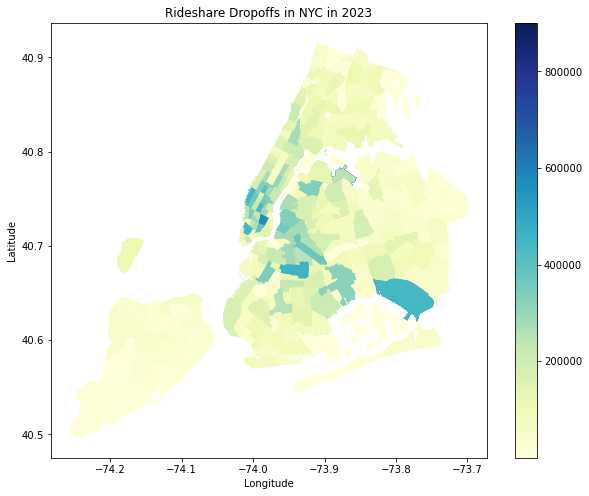

In [14]:
# Create Rideshare Choropleth
uber_lyft_dropoffs.plot(column='count_', cmap='YlGnBu', figsize=(10, 8), legend=True)
plt.title('Rideshare Dropoffs in NYC in 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Now that we have a rideshare choropleth for dropoffs by tract, lets look at the metro stop locations / density, as well as bike lines / stations in relation to rideshare dropoffs

For both cases, I used the size (specifically length since most blocks are rectangles) of a manhattan block as the buffer radius. I did not divide by 2 because I set the criterion to be that each station is within 2 block lengths to be the buffer size.

The same was done for citi bike stations.

In [15]:
# Look at Metro, Bike, Rideshare Intersections -> Create Buffers for Metro Stations, Bike Statinos

# Calculate buffer distance in relation to Manhattan blocks (used google for a rough estimate)
latitude_nyc = 40.7128  
longitude_nyc = -74.0060  
block_width_meters = 264 * 0.3048
block_length_meters = 900 * 0.3048
latitude_radians = math.radians(latitude_nyc)
longitude_radians = math.radians(longitude_nyc)

# Calculate the conversion factors for latitude and longitude
# I asked ChatGPT how to convert from meters to latitude / longitute degrees
latitude_conversion_factor = 111132.92 - 559.82 * math.cos(2 * latitude_radians) + 1.175 * math.cos(4 * latitude_radians) - 0.0023 * math.cos(6 * latitude_radians)
longitude_conversion_factor = 111412.84 * math.cos(latitude_radians) - 93.5 * math.cos(3 * latitude_radians)

# Convert block width and length to the same scale as latitude and longitude
block_width_degrees = block_width_meters / longitude_conversion_factor
block_length_degrees = block_length_meters / latitude_conversion_factor

In [16]:
for gdf in [bike_lane_low_income_intersections, low_income_bike_station_intersections, uber_lyft_dropoffs, nyc_subway_stops, low_income_census, nyc_gentrification, nyc_median_income]:
    print(f'CRS: {gdf.crs}')

CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326
CRS: epsg:4326


In [17]:
nyc_subway_stops.head(1)

,FID,stop_id,stop_name,stop_lat,stop_lon,trains,structure,stop_id2,GEOID,NAMELSAD,geometry
0,1,101,Van Cortlandt Park - 242 St,40.889248,-73.898583,1,Elevated,,36005,Bronx County,POINT (-73.89858 40.88926)


In [18]:
bike_stations.head(1)

,OBJECTID,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,geometry
0,1,330,00:01.5,05:31.8,3602,31 Ave & 34 St,40.763154,-73.920827,3570,35 Ave & 37 St,40.755733,-73.923661,20348,Subscriber,1992,1,POINT (-73.92083 40.76315)


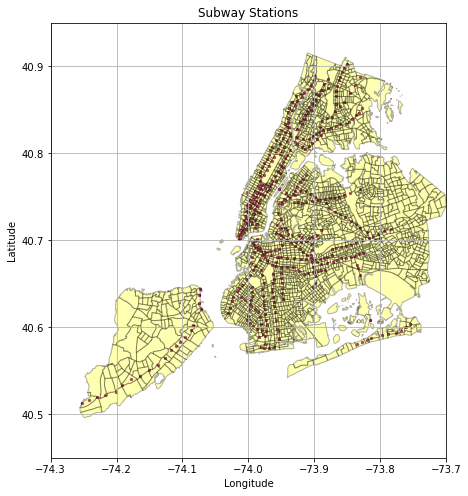

In [19]:
# Plot the subway stations
nyc_subway_stops.plot(marker='o', color='purple', markersize=5, figsize=(10, 8))
plt.title('Subway Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
nyc_boundaries.plot(ax=plt.gca(), alpha=0.3, color='yellow', edgecolor='black')
plt.xlim(-74.3, -73.7)
plt.ylim(40.45, 40.95)
plt.show()

### Create Buffers for Metro Stations Overlayed On Rideshare Dropoffs

/tmp/ipykernel_114/4144265210.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nyc_subway_buffer = nyc_subway_stops.buffer(block_length_degrees)


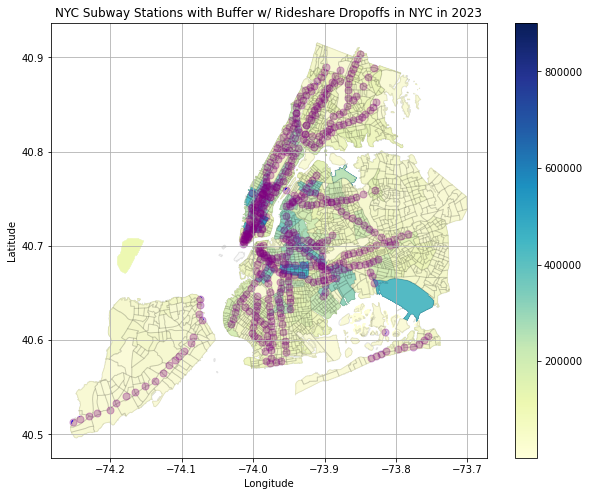

In [20]:
# Buffer around NYC subway stations
nyc_subway_buffer = nyc_subway_stops.buffer(block_length_degrees)
nyc_subway_stops['buffer'] = nyc_subway_buffer

# create map object: plot metro stop buffers
map1 = nyc_subway_stops['buffer'].plot(color='blue', alpha=1, figsize=(10, 8))
uber_lyft_dropoffs.plot(ax=map1, column='count_', cmap='YlGnBu', figsize=(10, 8), legend=True)
nyc_boundaries.plot(ax=map1, color='lightgray', alpha = .1, edgecolor='black')
nyc_subway_stops.plot(ax=map1, marker='o', color='purple', markersize=50, alpha = .3)

plt.title('NYC Subway Stations with Buffer w/ Rideshare Dropoffs in NYC in 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Create Buffers for Bike Stations Overlayed On Rideshare Dropoffs

/tmp/ipykernel_114/1637961634.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bike_stations_buffer = bike_stations.buffer(block_length_degrees)


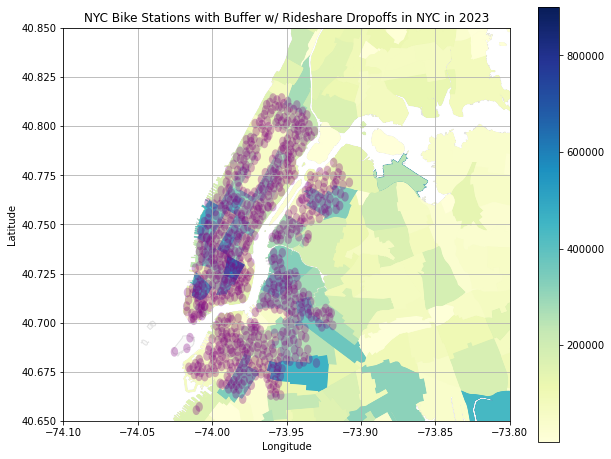

In [21]:
# Buffer around bike stations
bike_stations_buffer = bike_stations.buffer(block_length_degrees)  
bike_stations['buffer'] = bike_stations_buffer

# create map object: plot bike statino buffers
map2 = nyc_boundaries.plot(color='lightgray', alpha = .1, edgecolor='black', figsize=(10, 8))
uber_lyft_dropoffs.plot(ax=map2, column='count_', cmap='YlGnBu', legend=True)
bike_stations['buffer'].plot(ax=map2, color='purple', alpha=0.3)
#bike_stations.plot(ax=map2, marker='o', color='purple', markersize=50, alpha = .3)


plt.title('NYC Bike Stations with Buffer w/ Rideshare Dropoffs in NYC in 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.1, -73.8)
plt.ylim(40.65, 40.85)
plt.grid(True)
plt.show()

As we can see with metro station / bike station buffers, a big portion of Queens is underserved in both regards.
Brooklyn has a lot of bike stations as well as metro stops, and unsurprisingly Manhattan, especially lower Manhattan has the highest density of both bike stations and metro stops, with the buffers showing that nost of this region is covered with the 2 block radius criterion.

The next thing we will do is create choropleths for the metro station and bike station density. This will be useful later for our metric design.

### Aggregating Buffers Per Census Tract and Per Income Tract

#### Motivation:

We aggregate buffers instead of stations because buffers allow for a general area to be covered. Specifically, with a station on the border of a tract, it will only be counted in the tract it is in. However, with buffers, any buffers on the edge of a tract within 2 manhattan grid lengths will be counted in both tracts. This promotes the idea of walkability and accessability, since it is unrealistic to have a station right outside your front door!


In [22]:
nyc_boundaries.head(1) # our column to agg by is NTA2020

,OBJECTID,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape__Area,Shape__Length,geometry
0,1,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,1.842974e+06,10832.877284,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ..."


To start, let's look at just stations aggregated first, not their buffers:

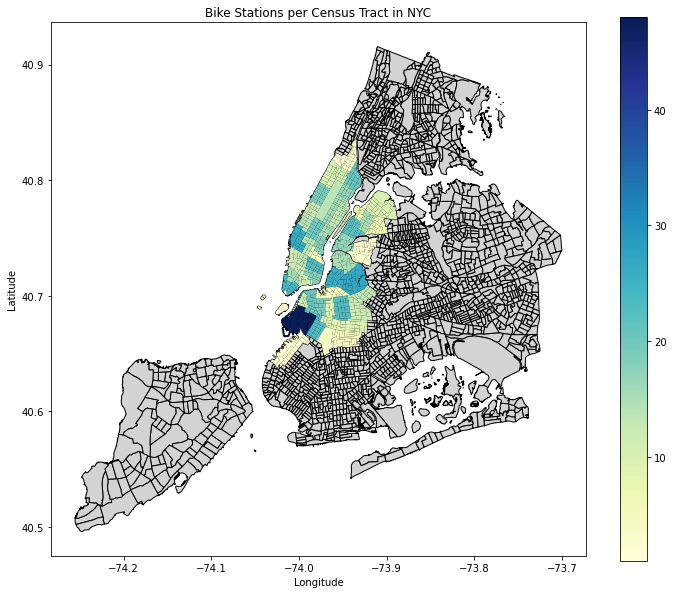

In [23]:
# 1. Perform spatial join
bike_stations_with_tracts = gpd.sjoin(gpd.GeoDataFrame(bike_stations), nyc_boundaries, how='inner', predicate='intersects')

# 2. Aggregate by census tract
bike_station_counts = bike_stations_with_tracts.groupby('NTA2020').size().reset_index(name='bike_station_count')

# 3. Merge aggregated counts back into nyc_boundaries
nyc_boundaries_with_counts = pd.merge(nyc_boundaries, bike_station_counts, on='NTA2020', how='left')

fig, ax = plt.subplots(figsize=(12, 10))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')
nyc_boundaries_with_counts.plot(ax=ax, column='bike_station_count', cmap='YlGnBu', figsize=(10, 8), legend=True)
plt.title('Bike Stations per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Wow, it looks like there are a lot underserved areas outside of downtown Brooklyn and Manhattan! Let's do the same for metro stations

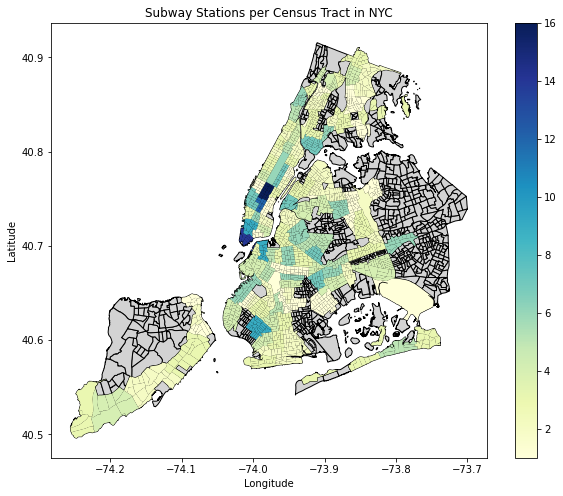

In [24]:
# 1. Perform spatial join
subway_stations_with_tracts = gpd.sjoin(gpd.GeoDataFrame(nyc_subway_stops), nyc_boundaries, how='inner', predicate='intersects')

# 2. Aggregate by census tract
subway_station_counts = subway_stations_with_tracts.groupby('NTA2020').size().reset_index(name='subway_station_count')

# 3. Merge aggregated counts back into nyc_boundaries
nyc_boundaries_with_subway_counts = pd.merge(nyc_boundaries, subway_station_counts, on='NTA2020', how='left')

fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')
nyc_boundaries_with_subway_counts.plot(ax=ax, column='subway_station_count', cmap='YlGnBu', figsize=(10, 8), legend=True)
plt.title('Subway Stations per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The first half of our analysis focused on the relationship between each method of transportation (Metro, Bike, and Rideshare) and the tracts / regions of NYC. Now we will look into whether income also correlates with these 3 methods of transportation.

### Overlay Buffers for each with Income Choropleth

In [25]:
# Look at income vs these intersections, (income vs metro, income vs bike, income vs rideshare)
# Do there apppear to be any correlations

To begin this half, let's look at income by tract before doing any overlays

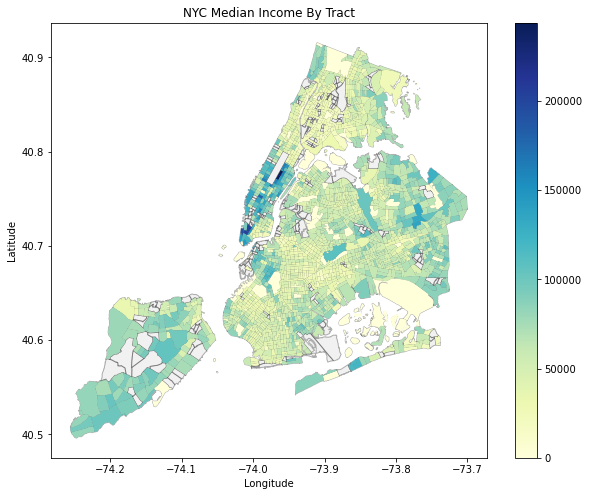

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black', alpha=.3)
nyc_median_income.plot(ax=ax, column='nyct2010_MedianInc', cmap='YlGnBu', legend=True)
plt.title('NYC Median Income By Tract')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Next, we look at metro and bike station buffers overlaid on income tracts

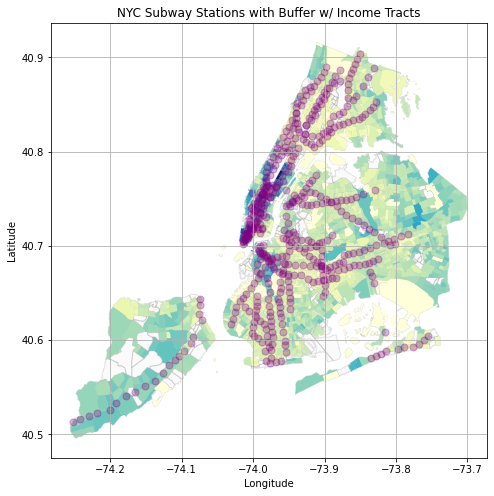

In [27]:
# create map object: plot metro stop buffers on income tracts
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', alpha = .1, edgecolor='black')
nyc_median_income.plot(ax=ax, column='nyct2010_MedianInc', cmap='YlGnBu')
nyc_subway_stops.plot(ax=ax, marker='o', color='purple', markersize=50, alpha = .3, legend=True)

plt.title('NYC Subway Stations with Buffer w/ Income Tracts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

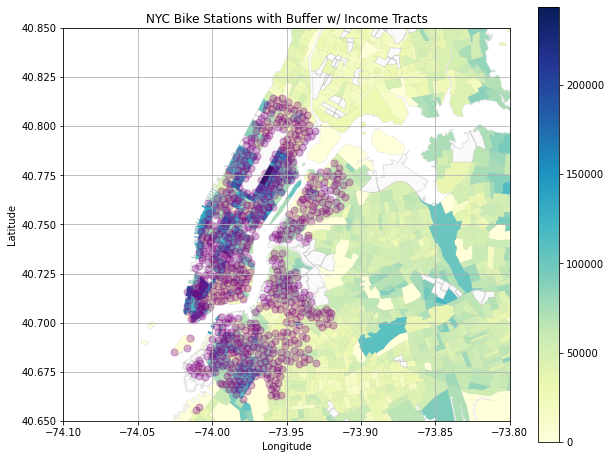

In [28]:
# create map object: plot bike station buffers on income tracts
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', alpha = .1, edgecolor='black')
nyc_median_income.plot(ax=ax, column='nyct2010_MedianInc', cmap='YlGnBu', legend=True)
bike_stations.plot(ax=ax, marker='o', color='purple', markersize=50, alpha = .3, legend=True)

plt.title('NYC Bike Stations with Buffer w/ Income Tracts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.1, -73.8)
plt.ylim(40.65, 40.85)
plt.grid(True)
plt.show()

### Putting these plots together: Buffers Per Tract 

Since we can't really overlay the choropleth layers without using a library like plotly, we will plot the aggregated layers below:

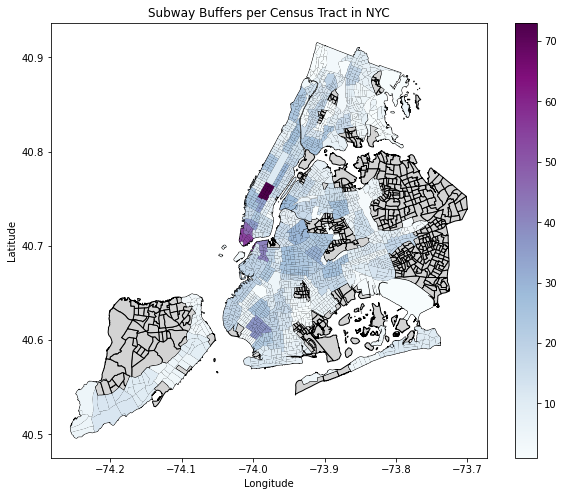

In [29]:
# 1. Perform spatial join
subway_stations_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry = nyc_subway_stops['buffer']), nyc_boundaries, how='inner', predicate='intersects')

# 2. Aggregate by census tract
subway_station_counts = subway_stations_with_tracts.groupby('NTA2020').size().reset_index(name='subway_buffer_count')

# 3. Merge aggregated counts back into nyc_boundaries
nyc_boundaries_with_subway_counts = pd.merge(nyc_boundaries, subway_station_counts, on='NTA2020', how='left')

fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')
nyc_boundaries_with_subway_counts.plot(ax=ax, column='subway_buffer_count', cmap='BuPu', figsize=(10, 8), legend=True)
plt.title('Subway Buffers per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

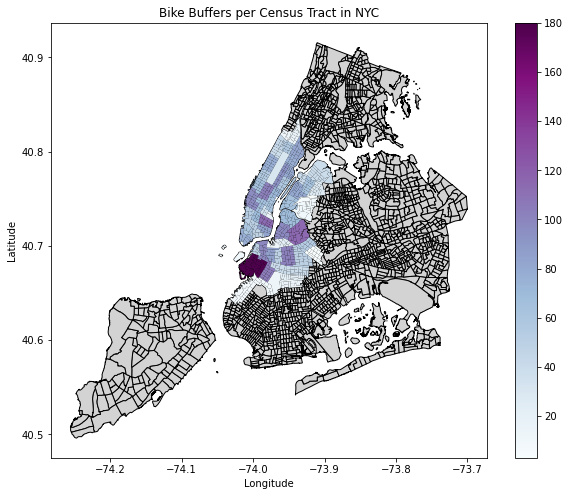

In [30]:
# 1. Perform spatial join
bike_stations_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry = bike_stations['buffer']), nyc_boundaries, how='inner', predicate='intersects')

# 2. Aggregate by census tract
bike_station_counts = bike_stations_with_tracts.groupby('NTA2020').size().reset_index(name='bike_buffer_count')

# 3. Merge aggregated counts back into nyc_boundaries
nyc_boundaries_with_bike_counts = pd.merge(nyc_boundaries, bike_station_counts, on='NTA2020', how='left')

fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')
nyc_boundaries_with_bike_counts.plot(ax=ax, column='bike_buffer_count', cmap='BuPu', figsize=(10, 8), legend=True)
plt.title('Bike Buffers per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see from the legends, the number of buffers per tract is larger than the number of stations, which supports our initial hypothesis about promoting walkability

With EDA finally done, we can start combining layers!

### Combining Choropleths

#### Outline
1. Get Buffers for Bike and Metro Station Choropleths per Census Tract into Columns (we have these already! `nyc_subway_stops['buffer']` and `bike_stations['buffer']`)
2. Spatial Join Bike, Metro, Rideshare per Tract
3. Create new column: $$\sum(.5 * \text{metro buffer}, .25 * \text{bike buffer}, .25 * \text{rideshare})$$ 

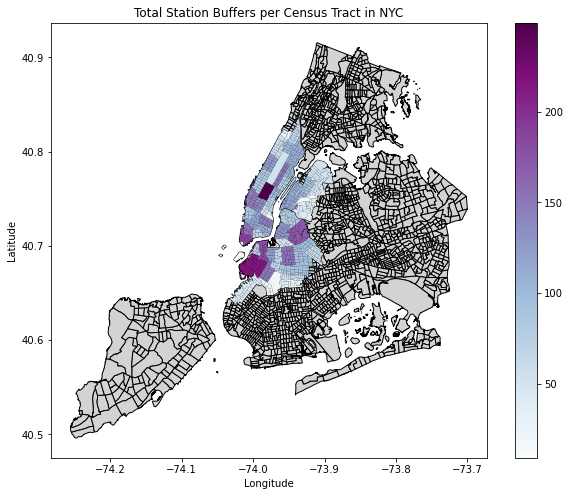

In [31]:
# Aggregate counts by census tract for subway, bike stations
subway_buffer_counts = subway_stations_with_tracts.groupby('NTA2020').size().reset_index(name='subway_buffer_count')
bike_buffer_counts = bike_stations_with_tracts.groupby('NTA2020').size().reset_index(name='bike_buffer_count')

# Merge aggregated counts back into nyc_boundaries
nyc_boundaries_with_subway_counts = pd.merge(nyc_boundaries, subway_buffer_counts, on='NTA2020', how='left')
nyc_boundaries_with_bike_counts = pd.merge(nyc_boundaries, bike_buffer_counts, on='NTA2020', how='left')

# Add the counts of subway station buffers and bike station buffers to get a sum
nyc_boundaries_with_subway_and_bike_counts = nyc_boundaries_with_subway_counts.copy()
nyc_boundaries_with_subway_and_bike_counts['total_buffer_count'] = 2 * nyc_boundaries_with_subway_and_bike_counts['subway_buffer_count'] + nyc_boundaries_with_bike_counts['bike_buffer_count']

# Plot the total station counts per census tract
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')
nyc_boundaries_with_subway_and_bike_counts.plot(ax=ax, column='total_buffer_count', cmap='BuPu', legend=True)
plt.title('Total Station Buffers per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [32]:
subway_buffer_counts.shape

(176, 2)

In [33]:
uber_lyft_dropoffs.groupby('PULocationID').count()

,OBJECTID_1,OBJECTID,Shape_Leng,zone,LocationID,borough,count_,DOLocationID,time_day,Shape__Area,Shape__Length,geometry
PULocationID,,,,,,,,,,,,
1.0,3,3,3,3,3,3,3,0,3,3,3,3
2.0,4,4,4,4,4,4,4,0,4,4,4,4
3.0,4,4,4,4,4,4,4,0,4,4,4,4
4.0,4,4,4,4,4,4,4,0,4,4,4,4
5.0,4,4,4,4,4,4,4,0,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
259.0,4,4,4,4,4,4,4,0,4,4,4,4
260.0,4,4,4,4,4,4,4,0,4,4,4,4
261.0,4,4,4,4,4,4,4,0,4,4,4,4


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# transform total count to get score

nyc_boundaries_with_subway_and_bike_counts['Accessibility_Score'] = np.log(nyc_boundaries_with_subway_and_bike_counts['total_buffer_count'])
nyc_boundaries_with_subway_and_bike_counts.head(3)

,OBJECTID,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape__Area,Shape__Length,geometry,subway_buffer_count,total_buffer_count,Accessibility_Score
0,1,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,1.842974e+06,10832.877284,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",3.0,15.0,2.708050
1,2,2.01,1,Manhattan,000201,1000201,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4103,9.723121e+05,4754.495247,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",11.0,69.0,4.234107
2,3,6,1,Manhattan,000600,1000600,None,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,4103,2.582705e+06,6976.286215,"POLYGON ((-73.99022 40.71441, -73.98934 40.714...",11.0,69.0,4.234107


As we can see, our model has high MSE. This is because of the transformation 

### Design Score / Metric for each Greater NYC adminstrative boundary 
$$\text{Accessability} = \log(\sum(.5 * \text{metro buffer}, .25 * \text{bike buffer}, .25 * \text{rideshare}))$$

- Compare with Income tracts to see if Low accessibility correlated w/ lower income 
- (if yes: reasons could be farther distance from metro, bike, uber buffers, less development in these areas)

### Goal of Metric: Reward highly accessible areas a lot and Punish highly inaccessible areas a lot
- Log() only rewards / punishes the most extremes, making it robust to outliers and safer for generalization
- cubic allows for a more skewed distribution of punishment / reward scaling since outliers are magnified exponentially

In [35]:
# Spatial join bike and metro buffers with census tracts
bike_buffers_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry=bike_stations['buffer']), nyc_boundaries, how='inner', predicate='intersects')
metro_buffers_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry=nyc_subway_stops['buffer']), nyc_boundaries, how='inner', predicate='intersects')

# Now, we have bike_buffers_with_tracts and metro_buffers_with_tracts with census tract information
# Aggregate the counts of bike and metro buffers per census tract
bike_buffers_counts = bike_buffers_with_tracts.groupby('NTA2020').size().reset_index(name='bike_buffers_count')
metro_buffers_counts = metro_buffers_with_tracts.groupby('NTA2020').size().reset_index(name='metro_buffers_count')

# Merge the counts back into nyc_boundaries
nyc_boundaries_with_buffers_counts = pd.merge(nyc_boundaries, bike_buffers_counts, on='NTA2020', how='left')
nyc_boundaries_with_buffers_counts = pd.merge(nyc_boundaries_with_buffers_counts, metro_buffers_counts, on='NTA2020', how='left')
counts_sum = uber_lyft_dropoffs.groupby('PULocationID')['count_'].sum()
dropoffs_normalized = (counts_sum - counts_sum.min()) / (counts_sum.max() - counts_sum.min())

# Calculate the weighted sum of metro, bike, and rideshare accessibility
bike_weight = 0.25
metro_weight = 0.50
rideshare_weight = .25

nyc_boundaries_with_buffers_counts['Accessibility_Score'] = (
    metro_weight * nyc_boundaries_with_buffers_counts['metro_buffers_count'] +
    bike_weight * nyc_boundaries_with_buffers_counts['bike_buffers_count'] +
    rideshare_weight * dropoffs_normalized
)

nyc_boundaries_with_buffers_counts['Accessibility_Score_Log'] = np.log(nyc_boundaries_with_buffers_counts['Accessibility_Score'])
nyc_boundaries_with_buffers_counts['Accessibility_Score_Cube'] = nyc_boundaries_with_buffers_counts['Accessibility_Score'] ** 2

Since the number of dropoffs per tract was quite large in comparison to the scale of metro and bike stops, we decided to normalize it. This yield better interpretability than not normalizing and just using a small weight.

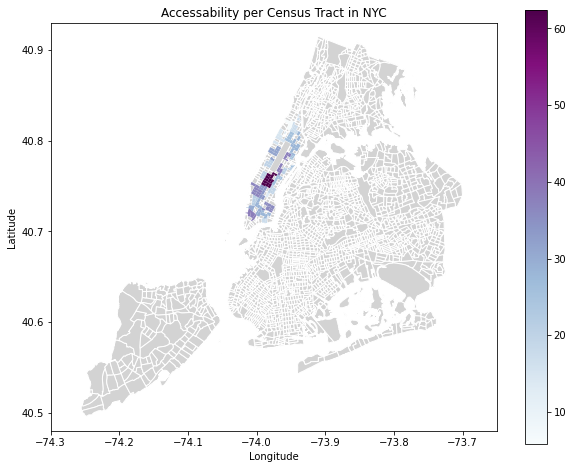

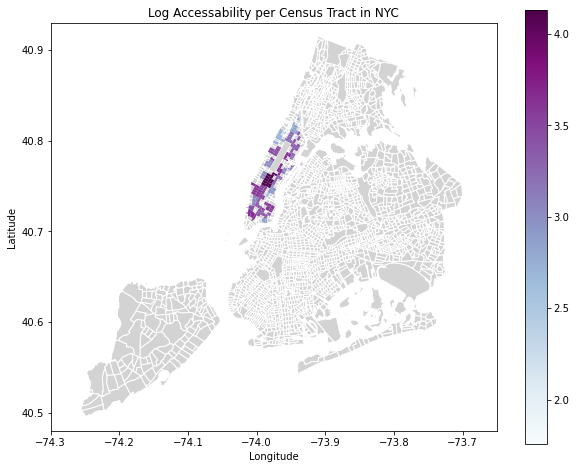

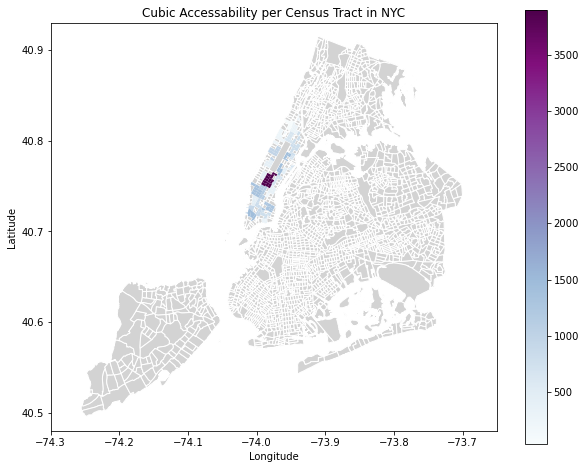

In [36]:
import numpy as np

def log(weighted_sum):
    scale_factor = .5 # Adjust this parameter to control the degree of transformation
    sign = np.sign(weighted_sum)
    abs_weighted_sum = np.abs(weighted_sum)
    transformed_value = np.where(abs_weighted_sum != 0, sign * np.log(abs_weighted_sum * scale_factor + 1), 0)
    return transformed_value

# Plot of the raw Accessability scores per census tract
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='white')
nyc_boundaries_with_buffers_counts.plot(ax=ax, column='Accessibility_Score',cmap='BuPu', legend=True)
plt.title('Accessability per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.3,-73.65)
plt.ylim(40.48,40.93)
plt.show()

# Plot of the log Accessability scores per census tract
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='white')
nyc_boundaries_with_buffers_counts.plot(ax=ax, column='Accessibility_Score_Log',cmap='BuPu', legend=True)
plt.title('Log Accessability per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.3,-73.65)
plt.ylim(40.48,40.93)
plt.show()

# Plot of the cube Accessability scores per census tract
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='white')
nyc_boundaries_with_buffers_counts.plot(ax=ax, column='Accessibility_Score_Cube',cmap='BuPu', legend=True)
plt.title('Cubic Accessability per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.3,-73.65)
plt.ylim(40.48,40.93)
plt.show()

In [37]:
# If time: regression to predict score based on income
# Join the GeoDataFrames with the Accessibility Scores and the median income values
access_income = gpd.sjoin(nyc_boundaries_with_buffers_counts, nyc_median_income, how='inner', predicate='intersects')
access_income_only = access_income[['geometry', 'Accessibility_Score','Accessibility_Score_Log','Accessibility_Score_Cube','nyct2010_MedianInc']]
access_income_only.head()

,geometry,Accessibility_Score,Accessibility_Score_Log,Accessibility_Score_Cube,nyct2010_MedianInc
0,"MULTIPOLYGON (((-74.04388 40.69020, -74.04351 ...",NaN,NaN,NaN,0
1,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",17.250000,2.847812,297.562500,24371
3,"POLYGON ((-73.98837 40.71645, -73.98754 40.716...",28.030703,3.333300,785.720303,24371
875,"POLYGON ((-73.97515 40.71459, -73.97517 40.714...",NaN,NaN,NaN,24371
923,"POLYGON ((-73.98058 40.71646, -73.98028 40.716...",NaN,NaN,NaN,24371


In [38]:
#Remove the rows that have NaN values for Accessibility Scores
access_income_only['Accessibility_Score'].isna().sum()
access_income_only_nona = access_income_only[access_income_only['Accessibility_Score'].notna()]
access_income_only_nona.head()

,geometry,Accessibility_Score,Accessibility_Score_Log,Accessibility_Score_Cube,nyct2010_MedianInc
1,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",17.250000,2.847812,297.562500,24371
3,"POLYGON ((-73.98837 40.71645, -73.98754 40.716...",28.030703,3.333300,785.720303,24371
1,"POLYGON ((-73.98450 40.70952, -73.98655 40.709...",17.250000,2.847812,297.562500,18832
2,"POLYGON ((-73.99022 40.71441, -73.98934 40.714...",17.250027,2.847814,297.563416,18832
3,"POLYGON ((-73.98837 40.71645, -73.98754 40.716...",28.030703,3.333300,785.720303,18832


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.preprocessing import StandardScaler

# Using Income to predict Accessibility_Score
X = access_income_only_nona[['nyct2010_MedianInc']]
y_raw = access_income_only_nona['Accessibility_Score']
y_log = access_income_only_nona['Accessibility_Score_Log']
y_cube = access_income_only_nona['Accessibility_Score_Cube']

# Normalize X and y
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the model to predict each Accessibility Score
ys = [y_raw,y_log,y_cube]
count = 0
for y in ys:

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if count == 0:
        print("Raw Accessibility Score")
    elif count == 1:
        print("Log Accessibility Score")
    else:
        print("Cubic Accessibility Score")
    count += 1
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
    print(f"R^2 Score: {r2_score(y_test, y_pred)}\n")

Raw Accessibility Score
Mean Squared Error: 147.38292181506796
R^2 Score: 0.11026527547049259

Log Accessibility Score
Mean Squared Error: 0.17850222818563263
R^2 Score: 0.13062076905070952

Cubic Accessibility Score
Mean Squared Error: 887027.5594199589
R^2 Score: 0.0798923084126627



## Integrating Crime

Previously we only looked at income with respect to the 3 public transportation methods, but we hypothesize that crime may also be impacted / correlated with public transport accessibility and income of a specific area.

To categorize crime, we analyze arrest data from the NYC Open Data Portal from January 2014 to April 2024. We categorize any arrest as crime. Note that this is different from calls of service, as an actual arrest must end up being made in order to be considered.

In [43]:
arrests = pd.read_csv('data/NYPD_Arrests_2014_to_2024.csv')
arrests.head(3)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,94283247,01/02/2014,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELONY",113.0,FORGERY,PL 1702500,F,K,71,...,995556.0,182337.0,40.667151,-73.959247,POINT (-73.95924696899993 40.66715066900008),13509.0,17.0,2.0,48.0,44.0
1,94275406,01/02/2014,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,M,32,...,1001372.0,240584.0,40.827015,-73.938134,POINT (-73.93813389499996 40.82701465700006),13097.0,18.0,4.0,36.0,20.0
2,94280550,01/02/2014,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN TIME",107.0,BURGLARY,PL 1402000,F,S,122,...,954801.0,148466.0,40.574140,-74.106008,POINT (-74.10600776499997 40.57414012800007),10693.0,30.0,1.0,14.0,76.0


In [52]:
# convert to a geo df
geometry = [Point(xy) for xy in zip(arrests['Longitude'], arrests['Latitude'])]
arrests_gdf = gpd.GeoDataFrame(arrests, geometry=geometry)

In [53]:
arrests_gdf.head(3)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,geometry
0,94283247,01/02/2014,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELONY",113.0,FORGERY,PL 1702500,F,K,71,...,182337.0,40.667151,-73.959247,POINT (-73.95924696899993 40.66715066900008),13509.0,17.0,2.0,48.0,44.0,POINT (-73.95925 40.66715)
1,94275406,01/02/2014,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,M,32,...,240584.0,40.827015,-73.938134,POINT (-73.93813389499996 40.82701465700006),13097.0,18.0,4.0,36.0,20.0,POINT (-73.93813 40.82701)
2,94280550,01/02/2014,244.0,"BURGLARY,UNCLASSIFIED,UNKNOWN TIME",107.0,BURGLARY,PL 1402000,F,S,122,...,148466.0,40.574140,-74.106008,POINT (-74.10600776499997 40.57414012800007),10693.0,30.0,1.0,14.0,76.0,POINT (-74.10601 40.57414)


In [60]:
arrests_gdf.columns

Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat', 'Zip Codes',
       'Community Districts', 'Borough Boundaries', 'City Council Districts',
       'Police Precincts', 'geometry'],
      dtype='object')

### Scatter Plot of Arrests w/ Opacity

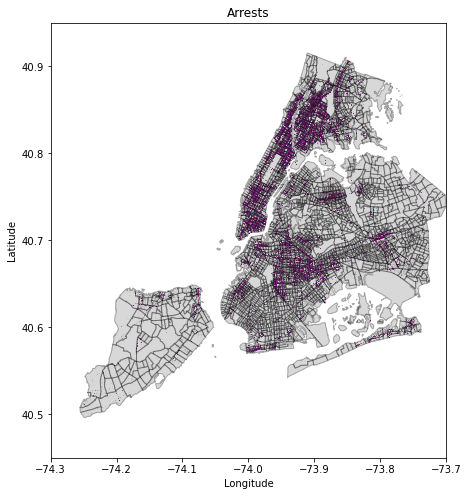

In [59]:
# Plot the arrest markers
arrests_gdf.plot(marker='o', color='purple', markersize=1, figsize=(10, 8), alpha=.003, legend=True)
plt.title('Arrests')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
nyc_boundaries.plot(ax=plt.gca(), alpha=0.3, color='gray', edgecolor='black')
plt.xlim(-74.3, -73.7)
plt.ylim(40.45, 40.95)
plt.show()

### Choropleth of Arrests per Tract

/tmp/ipykernel_114/884495722.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  arrests_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry = arrests['geometry']), nyc_boundaries, how='inner', predicate='intersects')


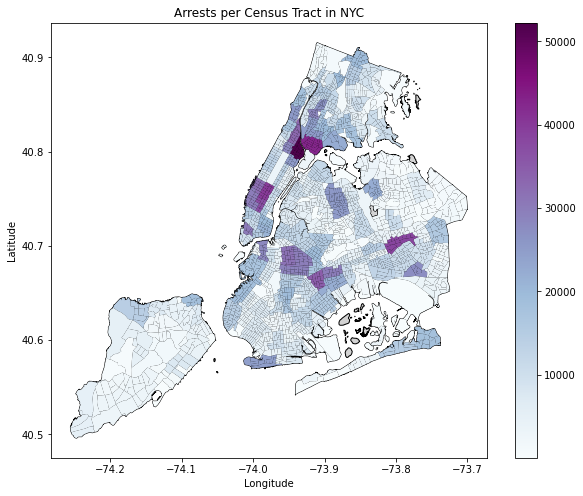

In [64]:
# 1. Perform spatial join
arrests_with_tracts = gpd.sjoin(gpd.GeoDataFrame(geometry = arrests['geometry'].to_crs('EPSG:4326')), nyc_boundaries, how='inner', predicate='intersects')

# 2. Aggregate by census tract
arrest_counts = arrests_with_tracts.groupby('NTA2020').size().reset_index(name='arrest_count')

# 3. Merge aggregated counts back into nyc_boundaries
nyc_boundaries_with_arrest_counts = pd.merge(nyc_boundaries, arrest_counts, on='NTA2020', how='left')

fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')
nyc_boundaries_with_arrest_counts.plot(ax=ax, column='arrest_count', cmap='BuPu', figsize=(10, 8), legend=True)
plt.title('Arrests per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Comparing Arrests vs Metro Buffer Count

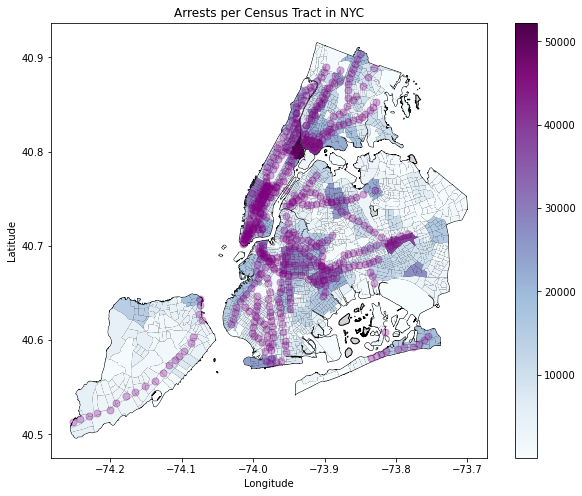

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
nyc_boundaries.plot(ax=ax, color='lightgray', edgecolor='black')
nyc_boundaries_with_arrest_counts.plot(ax=ax, column='arrest_count', cmap='BuPu', figsize=(10, 8), legend=True)
nyc_subway_stops.plot(ax=ax, marker='o', color='purple', markersize=50, alpha = .3, legend=True)
plt.title('Arrests per Census Tract in NYC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Comparing Arrests vs Income

### Summary & Results

Beginning with our EDA, we found that Manhattan metro stations had quite a lot of stops, with more of the underserved areas not being on the island. Additionally, this was more apparent with bike stations, as they were even more concentrated in Manhattan. Overlaying this with the median income choropleth, we saw that a huge number of the stations were also concentrated in Manhattan, with an even larger proportion being in downtown Brooklyn / DUMBO. When we switched to analyzing the counts of metro and bike stations and their buffer ranges being inclusive in counts, we saw a much smoother transition on the choropleths, but still the same overall correlation from the birdseye view. 

Overlaying these buffers on income, we used an transparent opacity for each buffer as well as a sequential color spectrum for the individual choropleth to see if the buffer density correlated with income as well. In all 4 plots, (Bike Buffers on Income Choropleth, Station Buffers on Income Choropleth, and Bike Buffer Count / Metro Buffer Count Choropleths) we saw that there still seemed to be a visible correlation, displayed by higher income / darker areas having more purple buffers.

To address the strength / validity of the correlation, we then designed a metric to first combine all 3 methods of transportation's buffers / points and aggregate by census tract, and then log transform it to be robust to outliers. We then used income to predict the accessibility score using a regression model with a tunable log transformation, resulting in an RMSE of .1785, which in our opinion is very admissible.

### Discussion
1. Uber Pickup Distribution and Income: Our findings corroborate the study by Scarlett T. Jin et al. (2019), which highlighted the unequal distribution of Uber services, particularly with fewer pickups in low-income areas. We observed a correlation between buffer density and income, indicating that underserved areas tend to have lower incomes. This supports the notion that transportation equity is closely tied to socioeconomic factors.

2. Spatio-Temporal Characteristics of Urban Travel Demand: Tang et al. (2019) emphasized the significance of various factors, including subway accessibility and point of interests, on travel demand. While our analysis focused on the spatial distribution of transportation services and income, it aligns with the broader understanding that multiple factors influence travel patterns and accessibility in urban areas.

3. Impact of Transit Proximity on Property Values: While not directly related to our analysis, the study by Hess and Almeida (2007) examined the impact of proximity to light rail transit on property values. Our findings complement this literature by highlighting the spatial distribution of transportation services and their potential association with property values and income levels. A potential addition to our analysis would be incorporating property values along with income to predict accessability.

4. Neighborhood Walkability and Active Travel: Freeman et al. (2013) highlighted the association between neighborhood walkability and active travel. While our analysis did not directly focus on active travel, it indirectly relates to the broader concept of transportation equity and accessibility, which can influence active modes of travel.

Our analysis extends the existing literature by providing a spatial perspective on transportation equity and accessibility in New York City. By integrating GIS data with socioeconomic data through a custom tunable accessability score, we identified spatial patterns of transportation services and their relationship with income levels. Additionally, our regression modeling approach provided quantitative insights into the relationship between transportation accessibility and income. The findings contribute to a better understanding of the complex interplay between transportation, socioeconomic factors, and spatial disparities in urban areas.

#### Trade-Offs and Decision Points:
Throughout the analysis, several trade-offs and decision points were considered:

1. Buffer Width: The choice of buffer width for subway and bike stations could impact the spatial representation of accessibility. We chose buffer widths based on practical considerations and the spatial extent of transportation services.

2. Spatial Operations: Spatial joins and overlays were utilized to integrate transportation data with census tract boundaries. These operations involved trade-offs in terms of computational complexity and accuracy, particularly when dealing with large datasets.

3. Machine Learning Techniques: The selection of machine learning techniques, such as regression modeling, involved considerations regarding model complexity, interpretability, and predictive performance.

Overall, through navigating these trade-offs we were able to conduct a comprehensive analysis that sparks discussion on transportation equity and accessibility in New York City.

### Conclusions & Future Work

From our current analysis, we did not *completely* answer our research question, however we did find results that suggest that our initial hypothesis was in the correct direction. Referring back to what we said,  we hypothesized that there are different factors whose effects that are correlated with some areas being under served specifically by the NYC metro such as these areas being more likely to experience more ride share and bike usage. 

Income ended up being one of these factors, and although we didn't make regression models involving gentrification and bike usage versus dropoffs, it is realistic and possible to find results from these that support our hypothesis. Additionally, if given more datasets with tracts, geometry, and some specific feature such as housing prices, zoning, and GDP / output, we believe that we could find correlations between these features and accessability as well.

What is great about this apprach we took was that it is replicable for other regions. The only factor stopping someone from performing the same analysis on another dense metropolitan area if the availability of the data, as well as how recent it is. Overall, given the data we were able to access, this project was successful, and at the current stage we were able to conclude a correlation between the different variables, while leaving some room on the table for different future analyses. 